In [84]:
import torch
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BayesianFlowNetwork(nn.Module):
    """
    Bayesian Flow Network (BFN) model.
    
    Parameters
    ----------
    D : int, default=2
        Dimensionality of the data.
    K : int, default=2
        Number of classes.
    hidden_dim : int, default=16
        Dimension of the hidden layer.
    """

    def __init__(self, D=2, K=2, hidden_dim=32, beta=3.0):
        super(BayesianFlowNetwork, self).__init__()
        self.beta = beta
        self.D = D
        self.K = K
        # Define the number of output classes based on K
        output_classes = K if K > 2 else 1

        # Define the neural network layers
        self.layer = nn.Sequential(
            nn.Linear(D * K + 1, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, D * output_classes)
        )

    def forward(self, theta, t):
        """
        Forward pass of the Bayesian Flow Network.
        
        Parameters
        ----------
        theta : torch.Tensor
            Tensor of shape (B, D, K).
        t : torch.Tensor
            Tensor of shape (B,).
        
        Returns
        -------
        torch.Tensor
            Output tensor of shape (B, D, K).
        """
        theta = (theta * 2) - 1  # scaled in [-1, 1]
        theta = theta.view(theta.shape[0], -1)  # (B, D * K)
        input_ = torch.cat((theta, t.unsqueeze(-1)), dim=-1)
        output = self.layer(input_)  # (B, D * K)
        output = output.view(output.shape[0], self.D, -1)
        return output

    
    def discrete_output_distribution(self, theta, t):
        """
        Computes the discrete output distribution.

        Algorithm 
        
        Parameters
        ----------
        theta : torch.Tensor
            Input tensor of shape (B, D, K).
        t : torch.Tensor
            Time tensor of shape (B,).
        
        Returns
        -------
        torch.Tensor
            Output probability tensor. For K=2, shape is (B, D, 2). 
            Otherwise, shape is (B, D, K).
        """
        B, D, K = theta.shape
    
        # Get the forward pass output and reshape
        output = self.forward(theta, t)
    
        # Check the number of classes and compute the output probabilities accordingly 
        if K == 2:
            p0_1 = torch.sigmoid(output)  # (B, D, 1)
            p0_2 = 1 - p0_1
            p0 = torch.cat((p0_1, p0_2), dim=-1)  # (B, D, 2)
        else:
            p0 = torch.nn.functional.softmax(output, dim=-1)
        return p0

    def process(self, x):
        B, D = x.shape
        # print(f"B {B}, D {D}")
        
        # Step 1: Sample t from U(0, 1)
        t = torch.rand((x.size(0),), device=x.device, dtype=torch.float32)

        # Step 2: Calculate Beta
        beta = self.beta * (t ** 2)  # (B,)

        # Step 3: Sample y from N(beta * (K * one_hot(X)) 
        one_hot_x = F.one_hot(x, num_classes=self.K).float()  # (B, D, K)
        mean = beta[:, None, None] * (self.K * one_hot_x - 1)
        std = (beta * self.K)[:, None, None].sqrt()
        eps = torch.randn_like(mean)
        y = mean + std * eps

        # Step 4: Compute the Theta
        theta = F.softmax(y, dim=-1)

        # Step 5: Calculate the output distribution
        p_0 = self.discrete_output_distribution(theta, t)  # (B, D, K)

        e_x = one_hot_x
        e_hat = p_0  # (B, D, K)
        L_infinity = self.K * self.beta * t[:, None, None] * ((e_x - e_hat) ** 2)
        return L_infinity.mean()

    @torch.inference_mode()
    def sample(self, batch_size=128, nb_steps=10, device='cpu'):
        self.eval()
        
        # get prior 
        theta = torch.ones((batch_size, self.D, self.K), device=device) / self.K

        for i in range(1, nb_steps+1):
            t = (i-1) / nb_steps
            t = t * torch.ones((theta.shape[0]), device=theta.device, dtype=theta.dtype)
            
            k_probs = self.discrete_output_distribution(theta, t)  # (B, D, K)
            k = torch.distributions.Categorical(probs=k_probs).sample()  # (B, D)
            alpha = self.beta * (2 * i - 1) / (nb_steps ** 2)

            e_k = F.one_hot(k, num_classes=self.K).float()  # (B, D, K)
            mean = alpha * (self.K * e_k - 1)
            var = (alpha * self.K)
            std = torch.full_like(mean, fill_value=var).sqrt()
            eps = torch.randn_like(e_k)
            
            y = mean + std * eps  # (B, D, K)
            
            theta_prime = torch.exp(y) * theta
            theta = theta_prime / theta_prime.sum(-1, keepdim=True)

        k_probs_final = self.discrete_output_distribution(theta, torch.ones_like(t))
        k_final = torch.distributions.Categorical(probs=k_probs_final).sample()

        return k_final

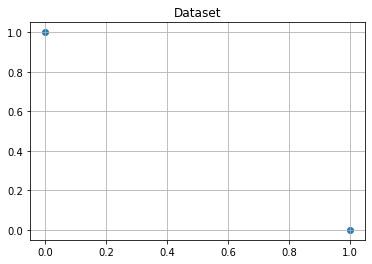

In [86]:

# network should learn:
# when x0 = 0, x1 = 1
# when x0 = 1, x1 = 0
def get_datapoint(batch=128, device='cpu'):
    x0 = torch.randint(0, 2, size=(batch,), dtype=torch.bool, device=device)
    x1 = ~x0

    X = torch.stack([x0, x1], dim=0)
    return X.long().transpose(0, 1)

X = get_datapoint()  # (B, D=2) with K=2 classes 

plt.title("Dataset")
plt.scatter(X[0, :], X[1, :]);
plt.grid()

  0%|          | 0/1000 [00:00<?, ?it/s]

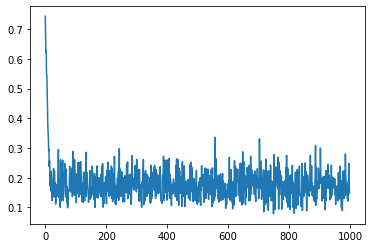

In [87]:
from torch.optim import AdamW
from tqdm.auto import tqdm

bfn = BayesianFlowNetwork()
bfn.cuda()

optim = AdamW(bfn.parameters(), lr=1e-2)


n = 1000
losses = []
for i in tqdm(range(n)):
    optim.zero_grad()

    X = get_datapoint(device='cuda')
    loss = bfn.process(X)
    loss.backward()

    optim.step()

    losses.append(loss.item())

plt.plot(losses)

In [88]:
x_hat = bfn.sample(device='cuda', nb_steps=100).cpu().numpy()
x_hat = x_hat + (np.random.randn(*x_hat.shape) * 0.1)

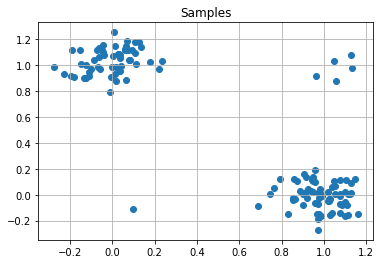

In [89]:
plt.title("Samples")
plt.scatter(x_hat[:, 0], x_hat[:, 1]);
plt.grid()